# This Notebook contains code to train mask classifiers the compiled image dataset

Face Analysis
* [Feature Extraction](#feat_ext)
* [Machine Learning Classifiers](#ml) 
* [Deep Learning with Keras](#dl)

Face Analysis with Additional Mask Annotation
* TODO: need to complete this part

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

from mtcnn.mtcnn import MTCNN # TODO: what is this?

# Load in Image Data and Labels from the Compiled Dataset



In [2]:
train = pd.read_csv('compiled_labels_km-annotated.csv')

display(train)



name   x1   x2   y1   y2       classname  \
0        1801.jpg  451  186  444  511    face_no_mask   
1        1802.jpg  160  151  108  114       face_mask   
2        1802.jpg  110   71  163  201  face_with_mask   
3        1803.jpg  147  200  141  120       face_mask   
4        1803.jpg  126   75  177  258  face_with_mask   
...           ...  ...  ...  ...  ...             ...   
20312  new_76.jpg  191  187  282  382    face_no_mask   
20313  new_78.jpg  126  200  335  370    face_no_mask   
20314  new_79.jpg  138  212  305  332    face_no_mask   
20315  new_90.jpg  133  263  346  316    face_no_mask   
20316  new_94.jpg  124  269  334  297    face_no_mask   

                           image_file_dir  
0      ../Dataset/mask_image_data/images/  
1      ../Dataset/mask_image_data/images/  
2      ../Dataset/mask_image_data/images/  
3      ../Dataset/mask_image_data/images/  
4      ../Dataset/mask_image_data/images/  
...                                   ...  
20312       ../Dataset/yolo/images/valid/  
20313       ../Dataset/yolo/images/valid/  
20314       ../Dataset/yolo/images/valid/  
20315       ../Dataset/yolo/images/valid/  
20316       ../Dataset/yolo/images/valid/  

[20317 rows x 7 columns]

# Plot Some Annotations

5949.jpg has 4 label(s)
10544    ../Dataset/mask_image_data/images/5949.jpg
10545    ../Dataset/mask_image_data/images/5949.jpg
10546    ../Dataset/mask_image_data/images/5949.jpg
10547    ../Dataset/mask_image_data/images/5949.jpg
Name: image_file_dir, dtype: object
['face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask']


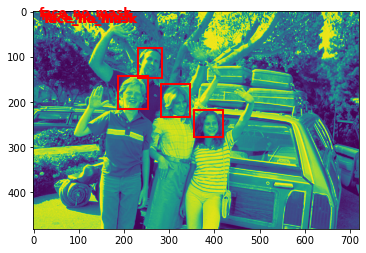

3808.png has 2 label(s)
5384    ../Dataset/mask_image_data/images/3808.png
5385    ../Dataset/mask_image_data/images/3808.png
Name: image_file_dir, dtype: object
['face_with_mask', 'face_mask']


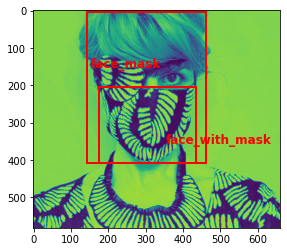

2194.png has 2 label(s)
1147    ../Dataset/mask_image_data/images/2194.png
1148    ../Dataset/mask_image_data/images/2194.png
Name: image_file_dir, dtype: object
['face_mask', 'face_with_mask']


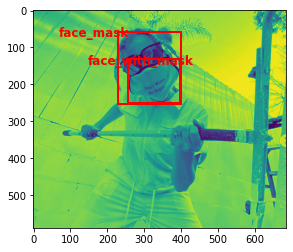

asian_mask125.jpg has 1 label(s)
18950    ../Dataset/yolo/images/train/asian_mask125.jpg
Name: image_file_dir, dtype: object
['face_with_mask']


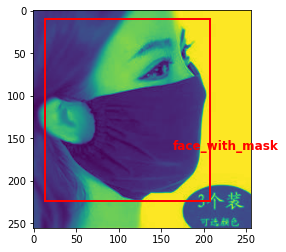

maksssksksss155.png has 4 label(s)
17356    ../Dataset/dataset_4/images/maksssksksss155.png
17357    ../Dataset/dataset_4/images/maksssksksss155.png
17358    ../Dataset/dataset_4/images/maksssksksss155.png
17359    ../Dataset/dataset_4/images/maksssksksss155.png
Name: image_file_dir, dtype: object
['face_with_mask', 'face_with_mask', 'face_with_mask', 'face_with_mask']


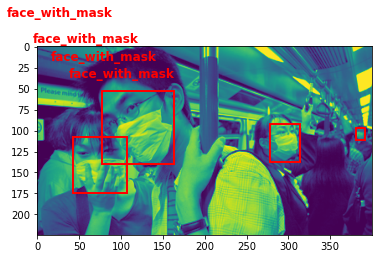

5121.jpg has 12 label(s)
9285    ../Dataset/mask_image_data/images/5121.jpg
9286    ../Dataset/mask_image_data/images/5121.jpg
9287    ../Dataset/mask_image_data/images/5121.jpg
9288    ../Dataset/mask_image_data/images/5121.jpg
9289    ../Dataset/mask_image_data/images/5121.jpg
9290    ../Dataset/mask_image_data/images/5121.jpg
9291    ../Dataset/mask_image_data/images/5121.jpg
9292    ../Dataset/mask_image_data/images/5121.jpg
9293    ../Dataset/mask_image_data/images/5121.jpg
9294    ../Dataset/mask_image_data/images/5121.jpg
9295    ../Dataset/mask_image_data/images/5121.jpg
9296    ../Dataset/mask_image_data/images/5121.jpg
Name: image_file_dir, dtype: object
['face_mask', 'face_mask', 'face_mask', 'face_mask', 'face_mask', 'face_with_mask', 'face_with_mask', 'face_with_mask', 'face_with_mask', 'face_with_mask', 'face_mask', 'face_with_mask']


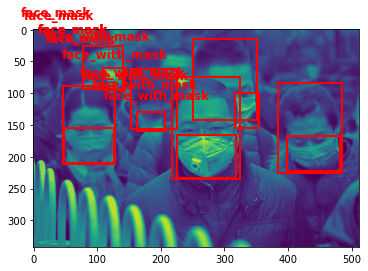

4086.png has 8 label(s)
6307    ../Dataset/mask_image_data/images/4086.png
6308    ../Dataset/mask_image_data/images/4086.png
6309    ../Dataset/mask_image_data/images/4086.png
6310    ../Dataset/mask_image_data/images/4086.png
6311    ../Dataset/mask_image_data/images/4086.png
6312    ../Dataset/mask_image_data/images/4086.png
6313    ../Dataset/mask_image_data/images/4086.png
6314    ../Dataset/mask_image_data/images/4086.png
Name: image_file_dir, dtype: object
['face_with_mask', 'face_with_mask', 'face_with_mask', 'face_mask', 'face_mask', 'face_mask', 'face_with_mask', 'face_mask']


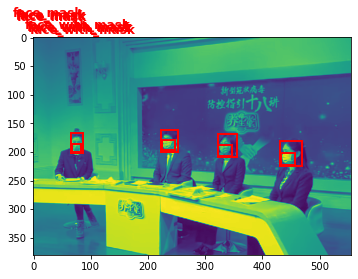

2984.png has 2 label(s)
3133    ../Dataset/mask_image_data/images/2984.png
3134    ../Dataset/mask_image_data/images/2984.png
Name: image_file_dir, dtype: object
['face_with_mask', 'face_mask']


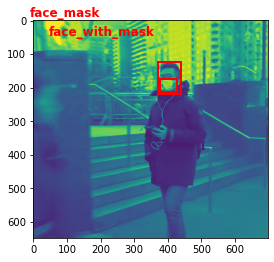

6004.jpg has 1 label(s)
10668    ../Dataset/mask_image_data/images/6004.jpg
Name: image_file_dir, dtype: object
['face_no_mask']


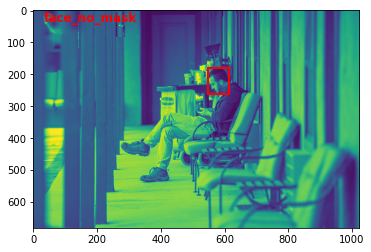

new_63.jpg has 2 label(s)
19915    ../Dataset/yolo/images/train/new_63.jpg
20305    ../Dataset/yolo/images/valid/new_63.jpg
Name: image_file_dir, dtype: object
['face_with_mask', 'face_with_mask']


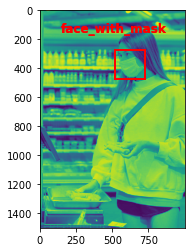

In [3]:
import random
def plot_image_with_all_bboxes(img_nm):
    dat = train[train['name'] == img_nm]
    print(img_nm,"has",len(dat),'label(s)')
    print(dat['image_file_dir']+img_nm)
    
    img = cv2.imread(dat.iloc[0]['image_file_dir']+img_nm,cv2.IMREAD_GRAYSCALE)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    class_name_ls = []
    for index,row in dat.iterrows():
        rect = patches.Rectangle(
            (row['x1'],row['x2']),
            row['y1'],
            row['y2'],
            linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(row['y2']-50, row['y2']-50, row['classname'], fontsize=12,color='r',fontweight='bold')
        class_name_ls.append(row['classname'])
    print(class_name_ls)
    plt.show()
name_ls =list(set(train['name']))
random.shuffle(name_ls)

for f in name_ls[0:10]:
    plot_image_with_all_bboxes(f)
    
    

# Plot Distribution of the Labels 

face_with_mask         11767
face_mask               4306
face_no_mask            2872
face_other_covering     1372
Name: classname, dtype: int64


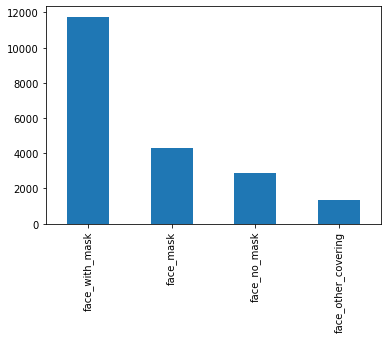

In [4]:
train.classname.value_counts().plot(kind='bar')
print(train.classname.value_counts())


# Get only training data corresponding to faces and masks

In [5]:
train = train.reset_index()
# Drop annotations for label face_other_covering
train_face = train[train['classname']!='face_other_covering']
train_face = train_face.reset_index()
display(train_face)

print(set(train_face['classname']))

level_0  index        name   x1   x2   y1   y2       classname  \
0            0      0    1801.jpg  451  186  444  511    face_no_mask   
1            1      1    1802.jpg  160  151  108  114       face_mask   
2            2      2    1802.jpg  110   71  163  201  face_with_mask   
3            3      3    1803.jpg  147  200  141  120       face_mask   
4            4      4    1803.jpg  126   75  177  258  face_with_mask   
...        ...    ...         ...  ...  ...  ...  ...             ...   
18940    20312  20312  new_76.jpg  191  187  282  382    face_no_mask   
18941    20313  20313  new_78.jpg  126  200  335  370    face_no_mask   
18942    20314  20314  new_79.jpg  138  212  305  332    face_no_mask   
18943    20315  20315  new_90.jpg  133  263  346  316    face_no_mask   
18944    20316  20316  new_94.jpg  124  269  334  297    face_no_mask   

                           image_file_dir  
0      ../Dataset/mask_image_data/images/  
1      ../Dataset/mask_image_data/images/  
2      ../Dataset/mask_image_data/images/  
3      ../Dataset/mask_image_data/images/  
4      ../Dataset/mask_image_data/images/  
...                                   ...  
18940       ../Dataset/yolo/images/valid/  
18941       ../Dataset/yolo/images/valid/  
18942       ../Dataset/yolo/images/valid/  
18943       ../Dataset/yolo/images/valid/  
18944       ../Dataset/yolo/images/valid/  

[18945 rows x 9 columns]

{'face_with_mask', 'face_mask', 'face_no_mask'}


# Only keep images associated with face_with_mask if include a face_mask annotation

In [6]:
face_mask_files = list(set(train_face[train_face['classname'] == 'face_mask']['image_file_dir']))
unmasked_face_files = list(set(train_face[train_face['classname'] == 'face_no_mask']['image_file_dir']))

print(face_mask_files)
print(unmasked_face_files)

train_face = train_face[((train_face['classname'] == 'face_with_mask') 
           & (train_face['image_file_dir'] == '../Dataset/mask_image_data/images/'))
           | (train_face['classname'] != 'face_with_mask')
          ]

train_face.sort_values(by = 'name',inplace=True)
display(train_face)


['../Dataset/mask_image_data/images/']
['../Dataset/mask_image_data/images/', '../Dataset/yolo/images/train/', '../Dataset/yolo/images/valid/', '../Dataset/dataset_4/images/']


level_0  index        name   x1   x2   y1   y2     classname  \
17378    18750  18750      10.jpg  145  200  336  344  face_no_mask   
18584    19956  19956     100.jpg  113  192  369  370  face_no_mask   
17379    18751  18751     100.jpg  113  192  369  370  face_no_mask   
17380    18752  18752     101.jpg  154  226  304  344  face_no_mask   
17381    18753  18753     102.jpg  141  238  391  347  face_no_mask   
...        ...    ...         ...  ...  ...  ...  ...           ...   
18579    19951  19951  new_94.jpg  124  269  334  297  face_no_mask   
18580    19952  19952  new_96.jpg  154  255  229  285  face_no_mask   
18581    19953  19953  new_97.jpg  123  226  301  329  face_no_mask   
18582    19954  19954  new_98.jpg  148  227  294  328  face_no_mask   
18583    19955  19955  new_99.jpg  146  193  313  353  face_no_mask   

                      image_file_dir  
17378  ../Dataset/yolo/images/train/  
18584  ../Dataset/yolo/images/valid/  
17379  ../Dataset/yolo/images/train/  
17380  ../Dataset/yolo/images/train/  
17381  ../Dataset/yolo/images/train/  
...                              ...  
18579  ../Dataset/yolo/images/train/  
18580  ../Dataset/yolo/images/train/  
18581  ../Dataset/yolo/images/train/  
18582  ../Dataset/yolo/images/train/  
18583  ../Dataset/yolo/images/train/  

[11508 rows x 9 columns]

<a id='feat_ext'></a>
# Extract only faces from images - keep annotations of mask locations
(This may take several minutes to run)

In [7]:
def overlapping_inner_rectangle(box1,box2):#,img):
    '''check if box2 is overlapping with box1 
        returns true if box2 d overlapping
    '''
    # make rectangles to make comparison easier
    a = patches.Rectangle(box1[0:2],box1[2],box1[3],linewidth=2,edgecolor='g',facecolor='none') # box1
    b = patches.Rectangle(box2[0:2],box2[2],box2[3],linewidth=2,edgecolor='r',facecolor='none') # box2

#     fig,ax = plt.subplots()
#     plt.imshow(img)
#     print(a)
#     print(b)
#     ax.add_patch(a)
#     ax.add_patch(b)
#     plt.show()
    
    # check if box1 and box2 overlap
    return ((a.get_bbox().x0 <= b.get_bbox().x1) and (a.get_bbox().x1 >= b.get_bbox().x0) and (a.get_bbox().y0 <= b.get_bbox().y1) and( a.get_bbox().y1 >= b.get_bbox().y0))


def find_overlapping(row,annot_df):
    for ind,rw in annot_df.iterrows():
        if overlapping_inner_rectangle(list(row[['x1','x2','y1','y2']]),list(rw[['x1','x2','y1','y2']])):
            return rw
    print("WARNING: no overlaps found")
    return None
        
    

1861.jpg cannot be formatted


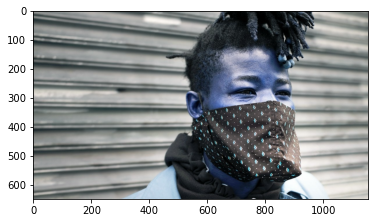

2053.jpg cannot be formatted


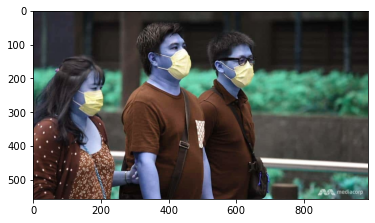

2053.jpg cannot be formatted


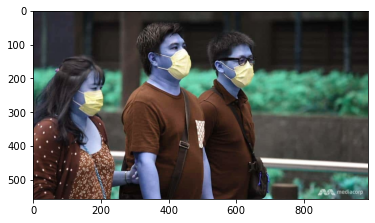

2053.jpg cannot be formatted


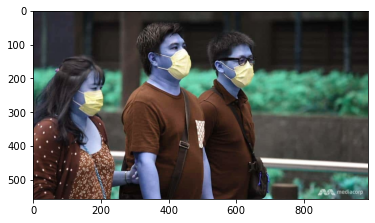

2054.jpg cannot be formatted


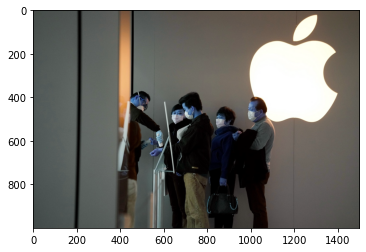

2054.jpg cannot be formatted


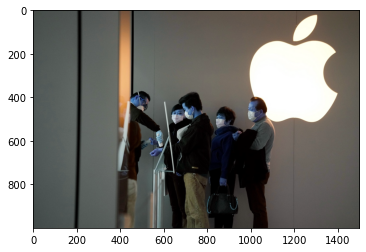

2054.jpg cannot be formatted


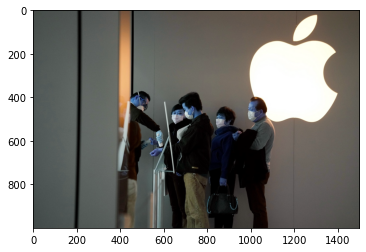

2054.jpg cannot be formatted


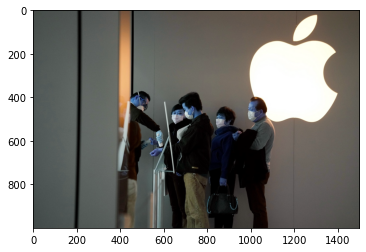

2054.jpg cannot be formatted


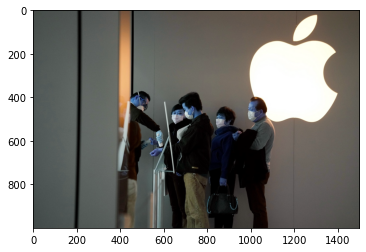

2148.jpg cannot be formatted


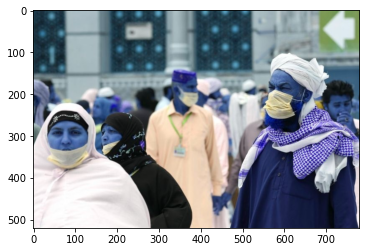

2573.png cannot be formatted


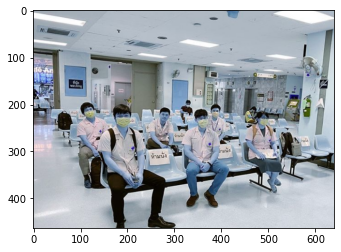

2617.png cannot be formatted


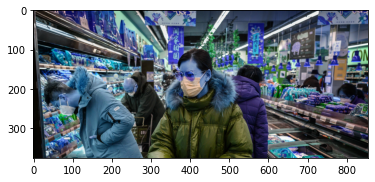

2741.png cannot be formatted


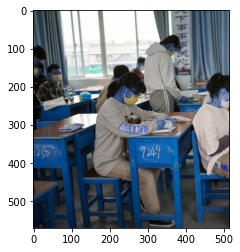

2794.png cannot be formatted


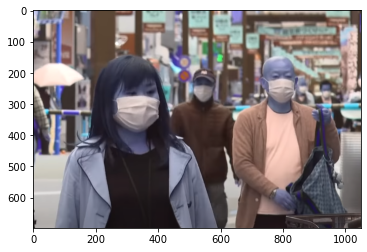

2895.png cannot be formatted


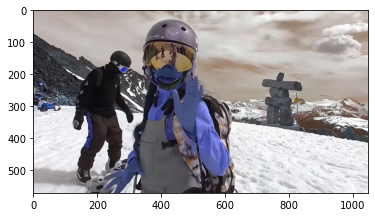

3020.png cannot be formatted


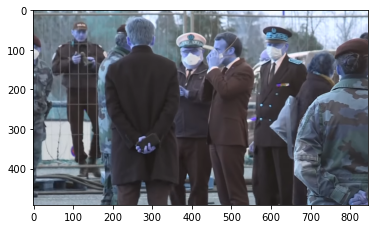

3123.png cannot be formatted


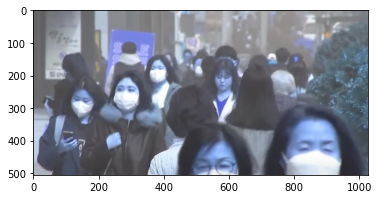

3415.png cannot be formatted


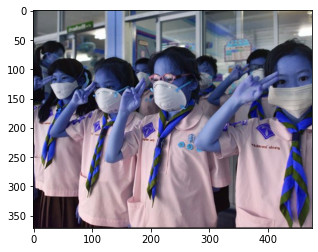

3469.png cannot be formatted


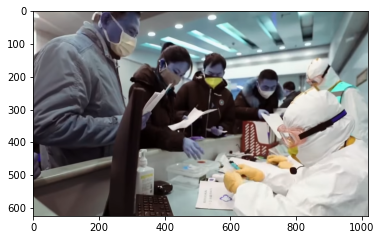

3524.png cannot be formatted


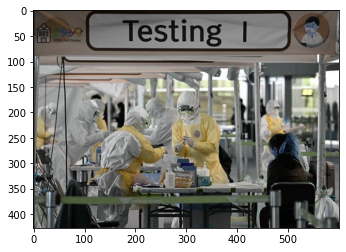

3524.png cannot be formatted


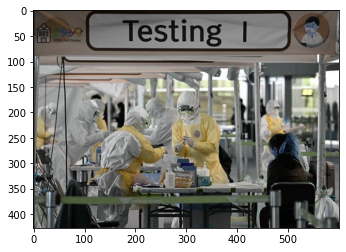

3591.png cannot be formatted


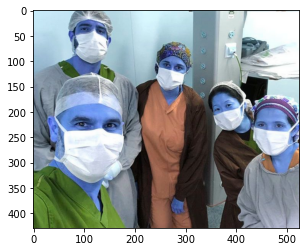

3614.png cannot be formatted


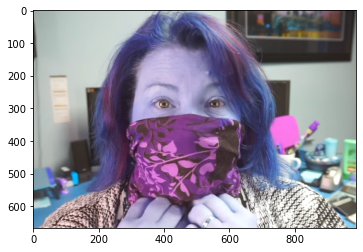

3746.png cannot be formatted


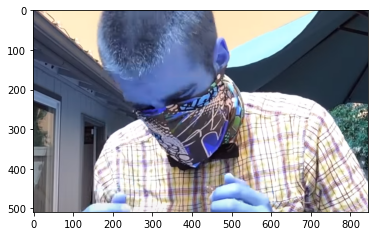

3807.png cannot be formatted


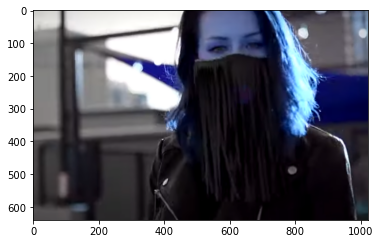

3954.png cannot be formatted


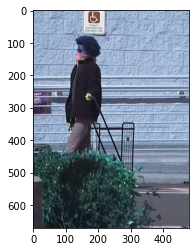

4185.png cannot be formatted


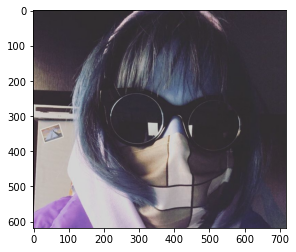

4322.png cannot be formatted


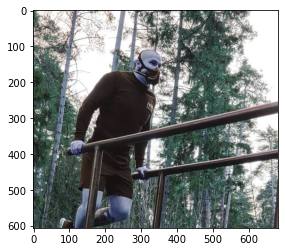

4620.png cannot be formatted


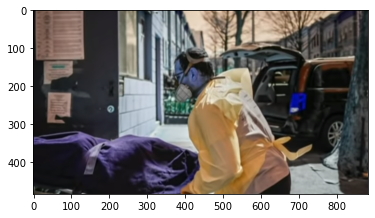

4737.png cannot be formatted


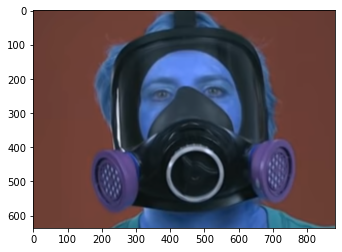

4781.png cannot be formatted


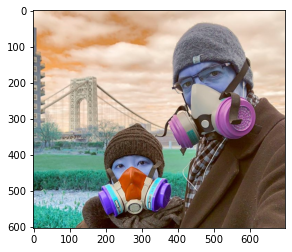

4781.png cannot be formatted


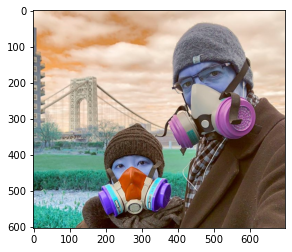

4785.png cannot be formatted


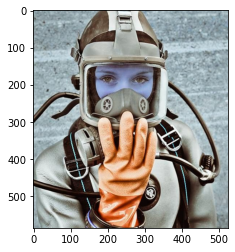

4934.png cannot be formatted


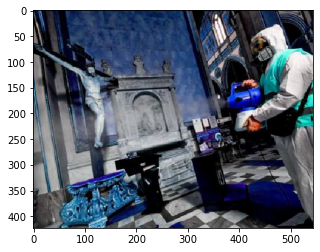

4948.png cannot be formatted


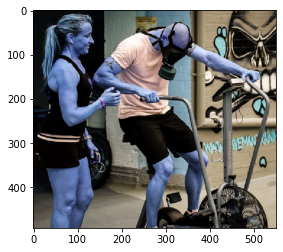

5480.jpg cannot be formatted


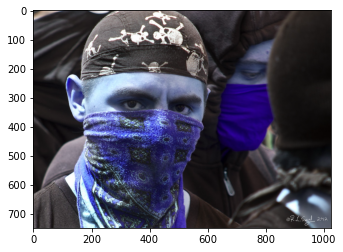

In [8]:
data=[]
path="../Dataset/compiled_data/"
to_drop = []
img_size = 224

# iterrate through masked faces only
for index, row in train_face[train_face['classname'] == "face_with_mask"].iterrows(): # only extract face annotation (NOT mask annotations)
    # reads in the image and converts it to greyscale 
    img_array=cv2.imread(row['image_file_dir']+row['name'],cv2.COLOR_BGR2RGB)#IMREAD_GRAYSCALE)#


    # crops the image to only include the face 
    crop_image = img_array[row['x2']:(row['y2']+row['x2']),
                           row['x1']:(row['y1']+row['x1'])]

    # Get mask annotations

    # get all annotations for this file name
    annot_df = (train_face[(train_face['name'] == row['name']) & (train_face['classname'] == "face_mask")])

    try:
        pos = 0
        if len(annot_df) > 1:
            rw = find_overlapping(row,annot_df)

            # identify location of mask within the cropped image
            rect = patches.Rectangle(
                (rw['x1']-row['x1'],rw['x2']-row['x2']), #(x,y)
                rw['y1'], # width
                rw['y2'], # height
                linewidth=2,edgecolor='r',facecolor='none',
            )

        else:

            # identify location of mask within the cropped image
            rect = patches.Rectangle(
                (annot_df.iloc[pos]['x1']-row['x1'],annot_df.iloc[pos]['x2']-row['x2']), #(x,y)
                annot_df.iloc[pos]['y1'], # width
                annot_df.iloc[pos]['y2'], # height
                linewidth=2,edgecolor='r',facecolor='none',
            )

        # scale factor
        x_scale = img_size/crop_image.shape[1]
        y_scale = img_size/crop_image.shape[0]

        rect_resized = patches.Rectangle(
            (int(np.round(rect.xy[0]*x_scale)),
             int(np.round(rect.xy[1]*y_scale))),
            int(np.round(rect.get_width()*x_scale)), # width
            int(np.round(rect.get_height()*y_scale)), # height
            linewidth=2,edgecolor='cyan',facecolor='none',
        )

        resized_image=cv2.resize(crop_image,(img_size,img_size))

#         fig,ax = plt.subplots(1)
#         plt.imshow(resized_image)
#         ax.add_patch(rect_resized)
#         plt.show()

        data.append([resized_image, rect_resized, 'face_with_mask'])

    except:
        fig,ax = plt.subplots(1)
        print(row['name'],"cannot be formatted")
        plt.imshow(img_array)
        plt.show()
        # keep track of those without the appropriate information and drop from the dataframe
        to_drop.append(index)
        data.append(-1)

        

# Now get unmasked images

In [9]:

# iterrate through unmasked faces only
for index, row in train_face[train_face['classname'] == "face_no_mask"].iterrows(): # only extract face annotation (NOT mask annotations)

    # reads in the image and converts it to greyscale 
    img_array=cv2.imread(row['image_file_dir']+row['name'],cv2.COLOR_BGR2RGB)#IMREAD_GRAYSCALE)#


    # crops the image to only include the face 
    crop_image = img_array[row['x2']:(row['y2']+row['x2']),
                           row['x1']:(row['y1']+row['x1'])]
    
    resized_image=cv2.resize(crop_image,(img_size,img_size))

#     fig,ax = plt.subplots(1)
#     plt.imshow(img_array)
#     plt.show()
    data.append([resized_image, None, 'face_no_mask'])
        


face_with_mask    4330
face_mask         4306
face_no_mask      2872
Name: classname, dtype: int64


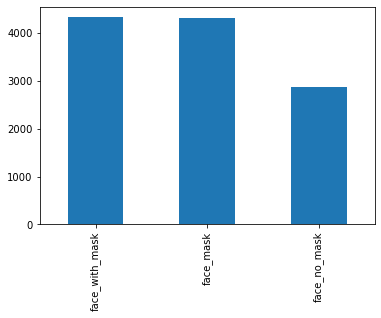

In [10]:
train_face.classname.value_counts().plot(kind='bar')
print(train_face.classname.value_counts())

In [11]:
len(data)


7202

# Some annotations of small faces cannot be included as we cannot generate a 50x50 image with them so will exclude for now
NOTE: other annotations of these same image files will be retained as they are valuable to our analysis

face_mask         4306
face_with_mask    4294
face_no_mask      2872
Name: classname, dtype: int64


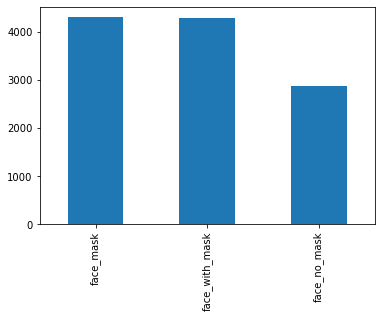

In [12]:
train_face.drop(to_drop, inplace=True)
train_face.classname.value_counts().plot(kind='bar')
print(train_face.classname.value_counts())
train_face.drop(columns = ['level_0','index'],inplace=True)
train_face = train_face.reset_index()

In [13]:
train_face

index        name   x1   x2   y1   y2     classname  \
0      17378      10.jpg  145  200  336  344  face_no_mask   
1      18584     100.jpg  113  192  369  370  face_no_mask   
2      17379     100.jpg  113  192  369  370  face_no_mask   
3      17380     101.jpg  154  226  304  344  face_no_mask   
4      17381     102.jpg  141  238  391  347  face_no_mask   
...      ...         ...  ...  ...  ...  ...           ...   
11467  18579  new_94.jpg  124  269  334  297  face_no_mask   
11468  18580  new_96.jpg  154  255  229  285  face_no_mask   
11469  18581  new_97.jpg  123  226  301  329  face_no_mask   
11470  18582  new_98.jpg  148  227  294  328  face_no_mask   
11471  18583  new_99.jpg  146  193  313  353  face_no_mask   

                      image_file_dir  
0      ../Dataset/yolo/images/train/  
1      ../Dataset/yolo/images/valid/  
2      ../Dataset/yolo/images/train/  
3      ../Dataset/yolo/images/train/  
4      ../Dataset/yolo/images/train/  
...                              ...  
11467  ../Dataset/yolo/images/train/  
11468  ../Dataset/yolo/images/train/  
11469  ../Dataset/yolo/images/train/  
11470  ../Dataset/yolo/images/train/  
11471  ../Dataset/yolo/images/train/  

[11472 rows x 8 columns]

# Plot Some Extracted Faces
two from each dataset

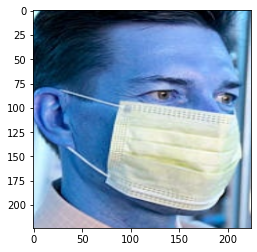

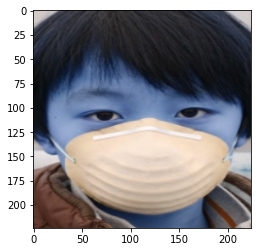

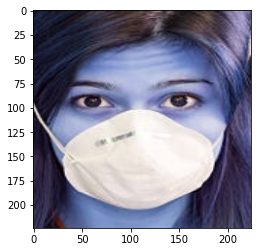

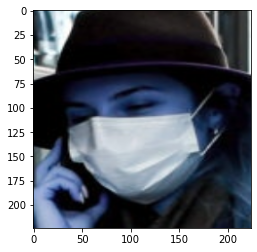

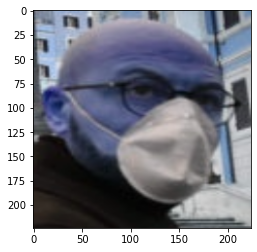

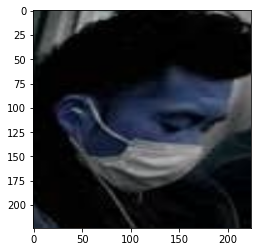

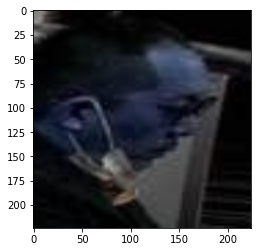

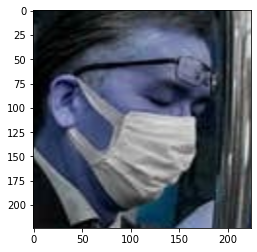

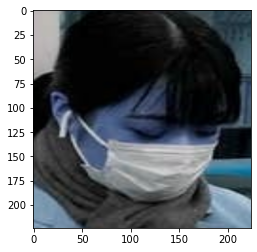

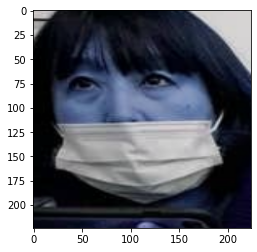

In [49]:
# plot example
fig,ax = plt.subplots()
for i in range(0,10):
    
    plt.imshow(data[i][0])
    try:
#         rect = patches.Rectangle((y_train[i][0],y_train[i][1]),y_train[i][2],y_train[i][3],linewidth=2,edgecolor='r',facecolor='none')
        new_rect=copy(data[i][1])
        ax.add_patch(new_rect)
    except:
        pass
    plt.show()
    
    

# Drop excluded annotations 
Drop elements in data that are -1 
Drop rows in train_face with indicies in to_drop

In [15]:
# Exclude annotations that could not be formatted
train_face = train_face.drop(to_drop)

initial_len = len(data)
data = [x for x in data if x != -1]

print("Dropped",len(to_drop),"images from train_face")
print("Dropped",initial_len-len(data),"faces from data")


Dropped 36 images from train_face
Dropped 36 faces from data


# Extract Labels and Features as x and y
### Convert labels to feature vector of 0's and 1's

In [50]:
# Extracts labels (mask/no mask) and features (50x50 vector of face image) and places them into x and y lists respectively
x=[]
y=[]
for features, rect, labels,  in data:
    x.append(features)
#     y.append(labels)
    try: # box label (mask)
        y.append(rect)#[rect.xy[0],rect.xy[1],rect.get_height(),rect.get_width()])
    except:# no box label (no mask)
        y.append(rect)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
# y=lbl.fit_transform(y)
print("y:",y[0:5])
print("x:",x[0:5])
# print("z:",z[0:5])


y: [<matplotlib.patches.Rectangle object at 0x7fa7aa96bc70>, <matplotlib.patches.Rectangle object at 0x7fa7a9fee250>, <matplotlib.patches.Rectangle object at 0x7fa7bfc694c0>, <matplotlib.patches.Rectangle object at 0x7fa7a9e11a90>, <matplotlib.patches.Rectangle object at 0x7fa7aa96bf10>]
x: [array([[[184, 234, 255],
        [180, 232, 255],
        [173, 227, 253],
        ...,
        [ 53, 113, 149],
        [ 47,  98, 132],
        [ 58, 103, 136]],

       [[200, 244, 250],
        [200, 246, 253],
        [195, 244, 254],
        ...,
        [ 57, 113, 149],
        [ 52, 100, 134],
        [ 58, 102, 133]],

       [[214, 251, 249],
        [214, 253, 252],
        [211, 253, 255],
        ...,
        [ 62, 114, 151],
        [ 58, 103, 137],
        [ 62, 103, 135]],

       ...,

       [[173, 188, 213],
        [172, 187, 210],
        [172, 185, 207],
        ...,
        [129, 155, 190],
        [122, 152, 188],
        [118, 150, 188]],

       [[172, 186, 205],
        [

<a id='split'></a>
### Partition Training set to use part for evaluating (because submission set is unlabelled)

In [51]:
import numpy as np
from sklearn.model_selection import train_test_split
sz = 0.2# 0.8 # size of test set partition

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=sz, random_state=42)


print("Full labelled dataset size:",len(x))
print("Splitting data into training/testing set with a "+str(sz*100)+"% partition")
print("Training set size:",len(x_train))
print("Test set size:",len(x_test))




Full labelled dataset size: 7166
Splitting data into training/testing set with a 20.0% partition
Training set size: 5732
Test set size: 1434


# Object Detection - detect mask in image


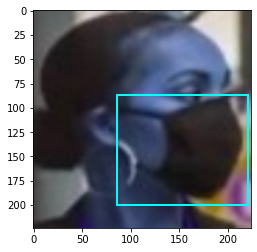

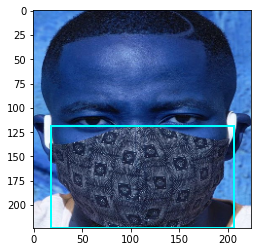

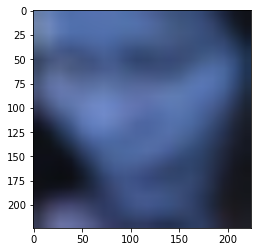

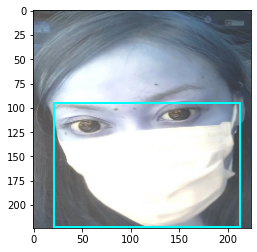

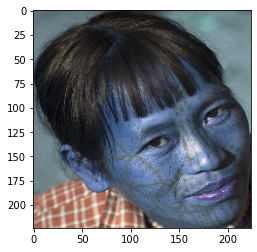

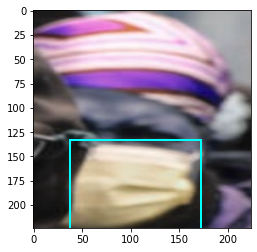

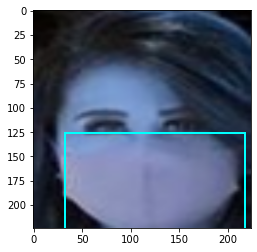

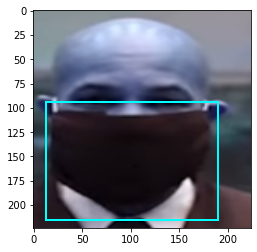

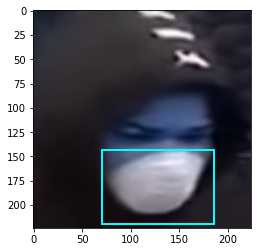

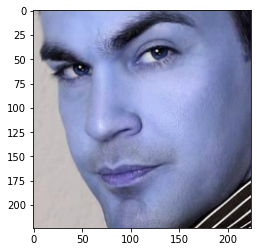

In [53]:
from mrcnn.utils import Dataset

# plot example
for i in range(0,10):
    fig,ax = plt.subplots()
    plt.imshow(x_train[i])
    if y_train[i] != None:
        rect =y_train[i]# patches.Rectangle((y_train[i][0],y_train[i][1]),y_train[i][2],y_train[i][3],linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

    
